# Predicting titanic passengers which will survive
In this notebook, we will analyze a dataset about titanic passengers and we will make a model which will predict which passengers will survive.
## Features:

- survival - Survival (0 = No, 1 = Yes)
- pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- sex - Sex
- Age - Age in years
- sibsp - # of siblings / spouses aboard the Titanic
- parch - # of parents / children aboard the Titanic
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin number
- embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Additional Info

**pclass**: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Target column:

- survival 

# Imports

In [790]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import OneClassSVM

# Importing the dataset

In [791]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [792]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As we see by this table, age column has 177 null columns.

In [793]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Preprocessing the data
### Dropping columns
As we see, passenger id, name and ticket number, we neither can encode them nor they are useful for our analysis.

In [794]:
df = df.drop('Name', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Cabin', axis=1)

Sex and Embarked should be encoded with OneHotEncoder and LabelEncoder, respectively.

In [795]:
one_hot_encoder = OneHotEncoder()
encoded = one_hot_encoder.fit_transform(df[['Sex']])
gender_encoded = pd.DataFrame(encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(['Sex']))
df = pd.concat([df.drop(columns=['Sex']), gender_encoded], axis=1)
label_encoder = LabelEncoder()
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,2,0.0,1.0
1,1,1,38.0,1,0,71.2833,0,1.0,0.0
2,1,3,26.0,0,0,7.9250,2,1.0,0.0
3,1,1,35.0,1,0,53.1000,2,1.0,0.0
4,0,3,35.0,0,0,8.0500,2,0.0,1.0


# Data visualization
## Scatter plot

<Axes: xlabel='Fare', ylabel='Age'>

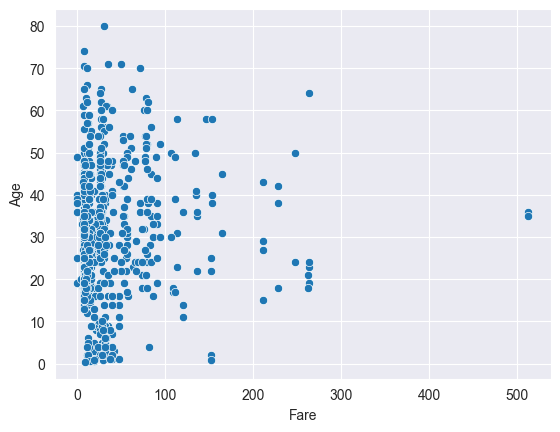

In [796]:
sns.scatterplot(x="Fare", y="Age", data=df)


Besides the fact that we see that most bought tickets are in the range between 0-100, we also see that more expensive tickets are bought by young adults. There are tickets sold for above 500, those could be some outliers.
## Contour plots 

<Axes: xlabel='Age', ylabel='Survived'>

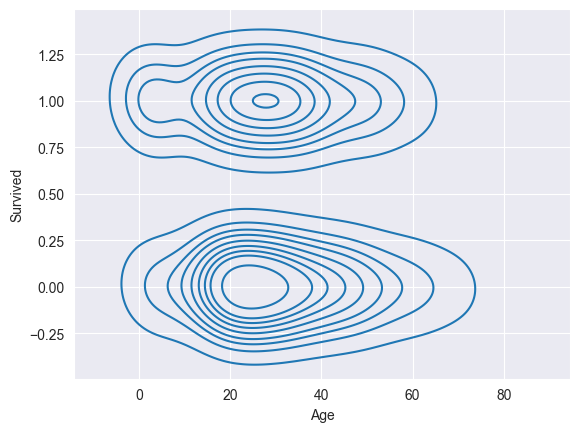

In [797]:
sns.kdeplot(x=df['Age'], y=df['Survived'])

Judging by the different length of the shapes, the oldest people who didn't survive are older than the oldest people that survived, also there is less data for people between ages of 20-30 who didn't survive.
## Histogram

<Axes: xlabel='Pclass', ylabel='Fare'>

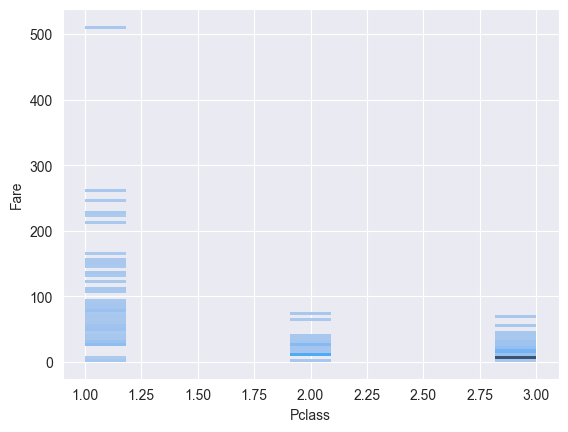

In [798]:
 sns.histplot(data=df, x='Pclass', y='Fare', stat='count')

As expected, fares for first class are higher than second and third class.
### Boxplot

<Axes: xlabel='Survived', ylabel='Age'>

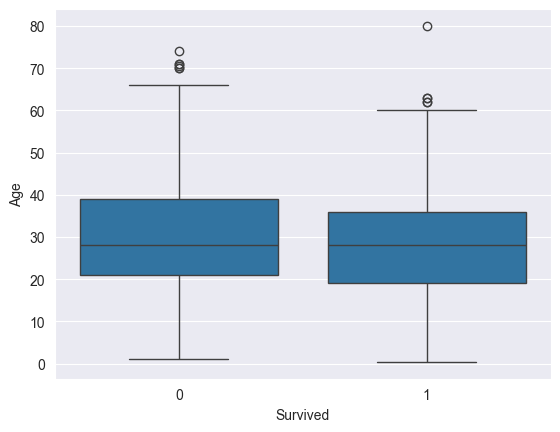

In [799]:
sns.boxplot(data=df, x='Survived', y='Age')

We see that people that survived are generally younger and passengers that are above 60 are considered outliers.
### Violinplot
Now, let's same data but with violinplot.

<Axes: xlabel='Survived', ylabel='Age'>

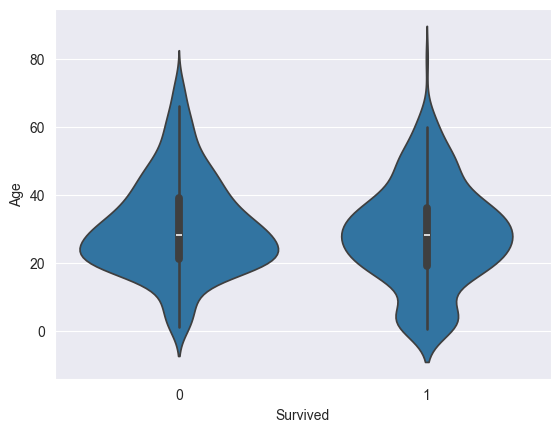

In [800]:
sns.violinplot(data=df, x='Survived', y='Age')

In this plot we can see, that young adults are the main demographic. Also we see that there are more children that survived than didn't.
### Pairplot


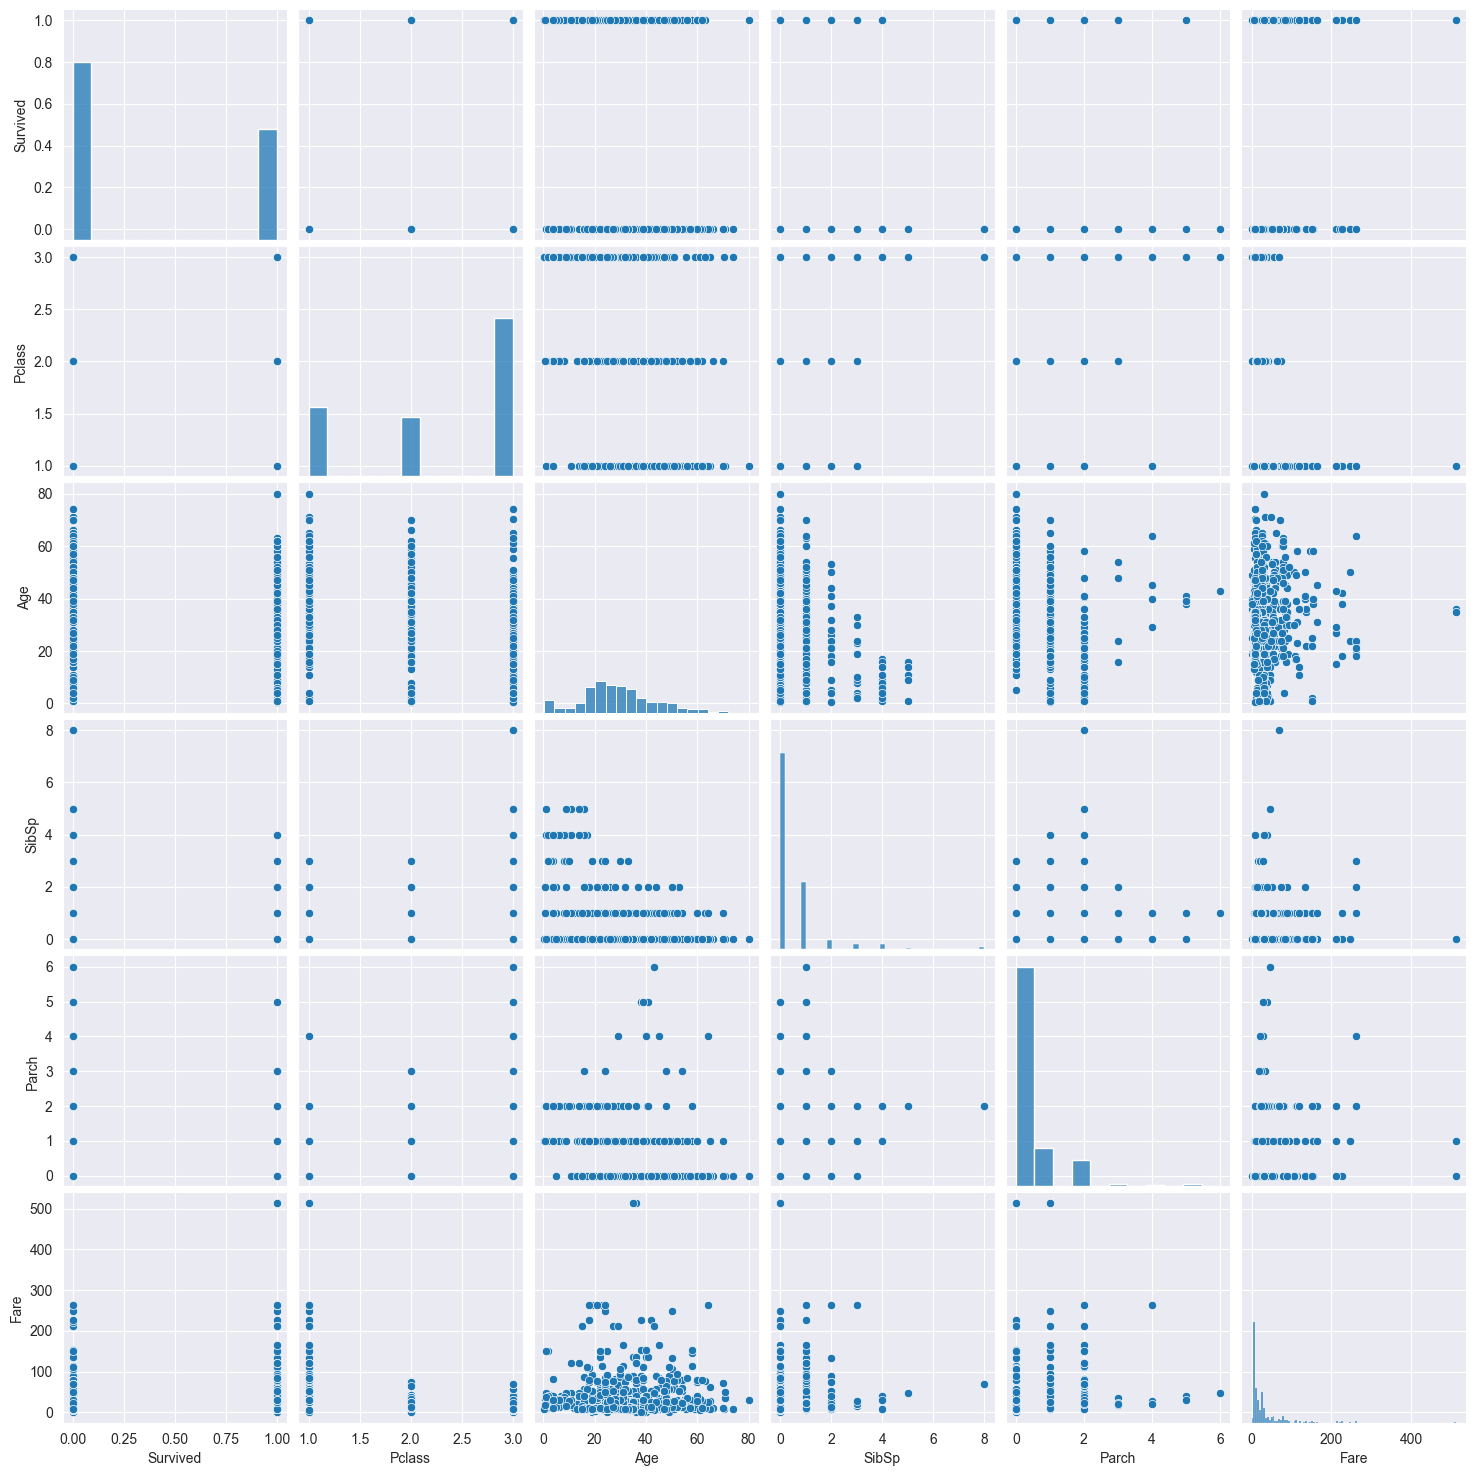

In [801]:
sns.pairplot(data=df, vars=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

In this plot, we can see the relations between each pair of attributes(we see some of plots we made before). Some observations: most people are in third class, have mostly no siblings or parents abroad, more people didn't survive.

# Finding outliers
## Finding 2 columns with greatest correlation for heatmanp

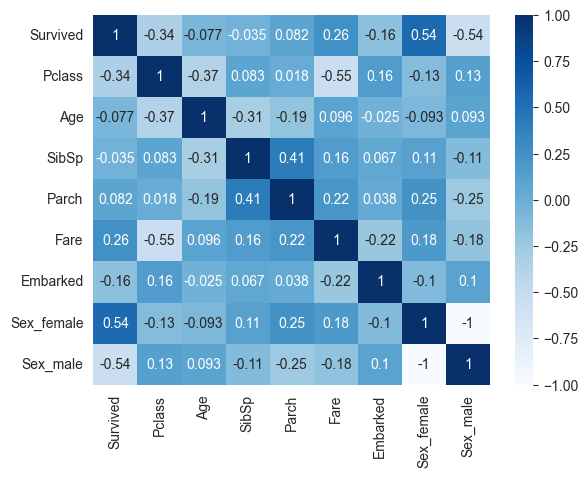

In [802]:
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Blues);

As seen in this image, the most correlation columns are sex and pclass having a score of 0.54 and -0.34 respectively.

## Training models for detection
We will try 4 models: Isolation Forest, OneClassSVM, EllipticEnvelope and LocalOutlierFactor

In [803]:
df_subset = df[['Pclass', 'Sex_male', 'Survived']]

# Models
models = {
    "Isolation Forest": IsolationForest(contamination=0.1),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel='rbf', gamma='scale'),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.1),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1)
}

outlier_preds = {}
for model_name, model in models.items():
    if model_name == "Local Outlier Factor":
        outlier_preds[model_name] = model.fit_predict(df_subset[['Pclass', 'Sex_male']])
    else:
        model.fit(df_subset[['Pclass', 'Sex_male']])
        outlier_preds[model_name] = model.predict(df_subset[['Pclass', 'Sex_male']])

### Creating a scatter plot of the results

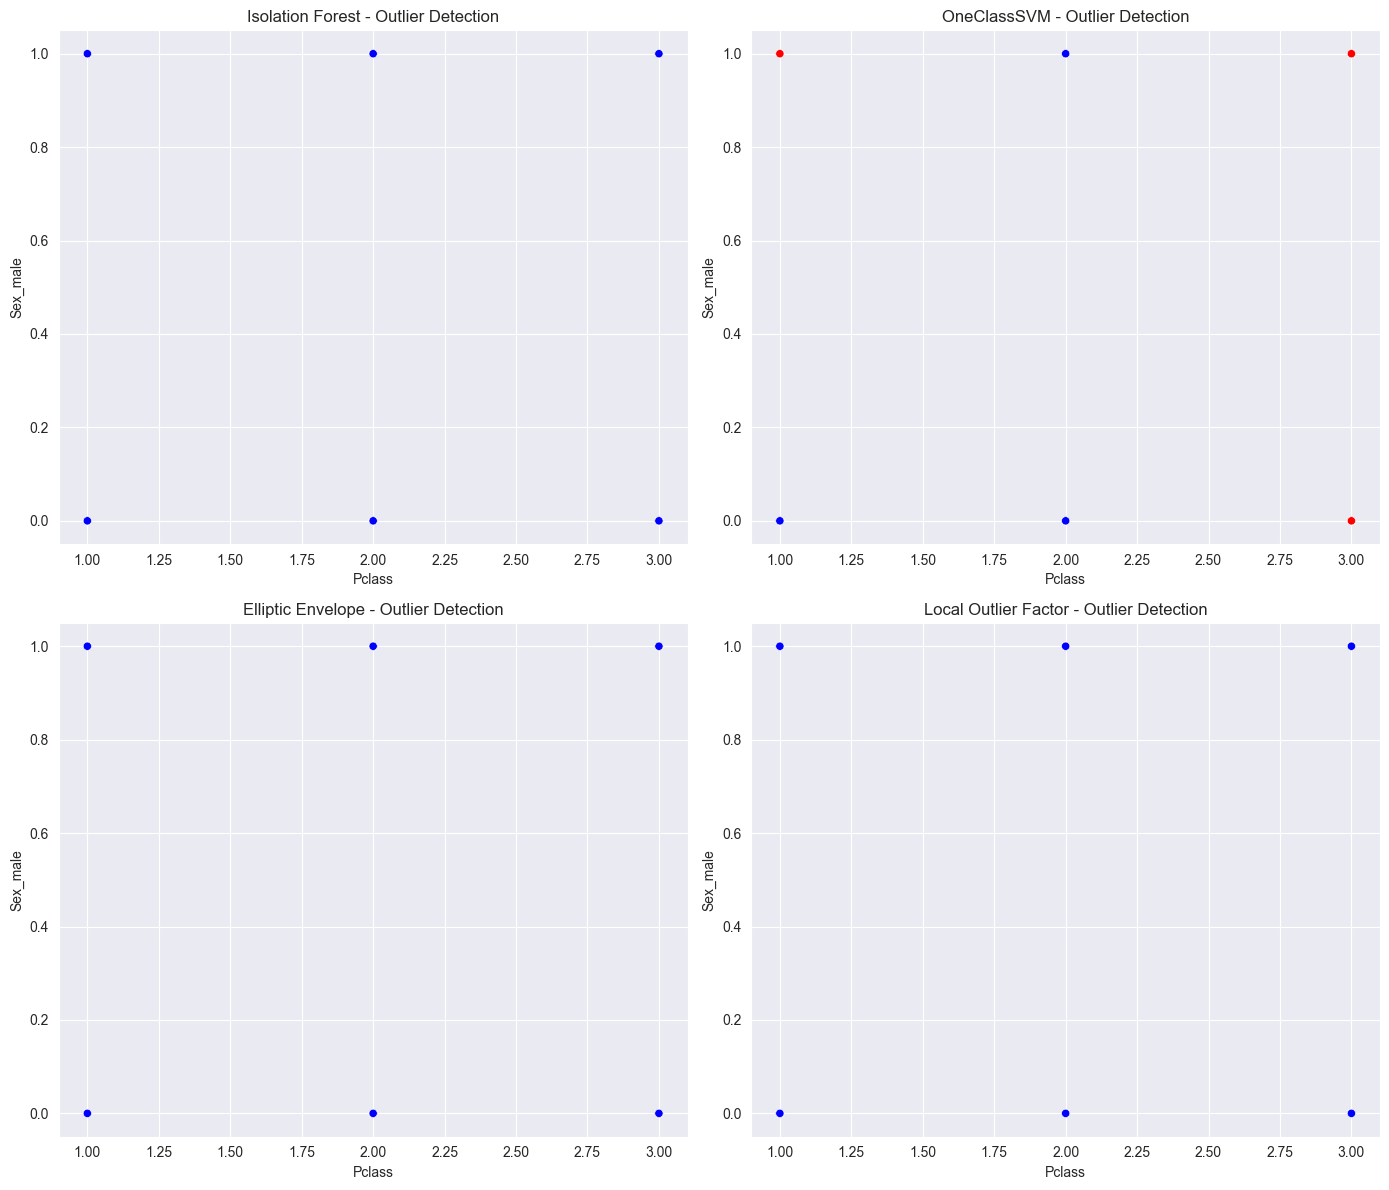

In [804]:
outlier_preds_df = pd.DataFrame(outlier_preds)
outlier_preds_df = outlier_preds_df.map(lambda x: 'Outlier' if x == -1 else 'Normal')

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

model_names = ["Isolation Forest", "OneClassSVM", "Elliptic Envelope", "Local Outlier Factor"]

for i, model_name in enumerate(model_names):
    ax = axes[i//2, i%2]
    predictions = outlier_preds_df[model_name]
    scatter_colors = predictions 
    
    sns.scatterplot(x=df_subset['Pclass'], y=df_subset['Sex_male'], hue=scatter_colors, palette={'Normal': 'blue', 'Outlier': 'red'}, ax=ax, legend=False)
    
    ax.set_xlabel('Pclass')
    ax.set_ylabel('Sex_male')
    ax.set_title(f'{model_name} - Outlier Detection')

plt.tight_layout()
plt.show()

As seen from this plots, IsolationForest and LocalOutlierFactor have not found any outliers while OneClassSVM has found most outliers - males in first class and 3rd class and women in 3rd class. The reason why other algorithm didn't detect outliers is probably because they work better with linear data but not with classification data as in this case. 

## Training models 
We will use only data from OneClassSVM, since it is the only one which has detected outlier.

In [805]:
df_subset = df[['Pclass', 'Sex_male', 'Survived']]
X = df_subset[['Pclass', 'Sex_male']]
y = df_subset['Survived']

outlier_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')

classification_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

outlier_model.fit(X_train[['Pclass', 'Sex_male']])
preds = outlier_model.predict(X_train[['Pclass', 'Sex_male']])
X_train_cleaned = X_train[preds == 1] 
y_train_cleaned = y_train[preds == 1]

results = []

for clf_name, clf_model in classification_models.items():
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    accuracy_orig = accuracy_score(y_test, y_pred)
    precision_orig = precision_score(y_test, y_pred)
    recall_orig = recall_score(y_test, y_pred)
    f1_orig = f1_score(y_test, y_pred)

    clf_model.fit(X_train_cleaned, y_train_cleaned)
    y_pred_cleaned = clf_model.predict(X_test)
    accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)
    precision_cleaned = precision_score(y_test, y_pred_cleaned)
    recall_cleaned = recall_score(y_test, y_pred_cleaned)
    f1_cleaned = f1_score(y_test, y_pred_cleaned)

    results.append({
        "Outlier Detection": "OneClassSVM",
        "Model": clf_name,
        "Accuracy Original": accuracy_orig, "Precision Original": precision_orig,
        "Recall Original": recall_orig, "F1 Original": f1_orig,
        "Accuracy Cleaned": accuracy_cleaned, "Precision Cleaned": precision_cleaned,
        "Recall Cleaned": recall_cleaned, "F1 Cleaned": f1_cleaned
    })

results_df = pd.DataFrame(results)
results_df

,Outlier Detection,Model,Accuracy Original,Precision Original,Recall Original,F1 Original,Accuracy Cleaned,Precision Cleaned,Recall Cleaned,F1 Cleaned
0,OneClassSVM,Logistic Regression,0.773109,0.738095,0.659574,0.696629,0.756303,0.648352,0.836879,0.730650
1,OneClassSVM,Random Forest Classifier,0.770308,0.915493,0.460993,0.613208,0.753501,0.708661,0.638298,0.671642


As seen in the table, accuracy and precision have been lowered while recall and f1 scores has been improved after cleaning outliers, which means as our recall increases, our precision decreases because, in addition to increasing the true positives, we increase the false positives.